<a href="https://colab.research.google.com/github/tschroeder10961/datascience-urban-segregation/blob/master/population_Berlin_Brandenburg_FS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Topic: growth of the "Capital Region" Berlin-Brandenburg**



## Introduction

The German capital Berlin and it's surrounding state Brandenburg have always had a close connection in terms of economy, infrastructure, labour market, housing market and other supplies. As a consequence of the region's rich history and close relation, a merger of the two states was attempted in 1996. However, it was rejected in a referendum by the populations of the two states. Since then, the connections are still close, especially in terms of labour market and housing market. Many people live in Brandenburg and work in Berlin and vice versa. The region's coordination is regulated by the joint state planning of Berlin and Brandenburg (Gemeinsame Landesplanung Berlin Brandenburg).

One of the main concerns of this coordination office is the planning of the different areas with the help of the „Landesentwicklungsplan Hauptstadtregion Berlin-Brandenburg“ ([Regional Development Plan of the Capital Region Berlin-Brandenburg](https://gl.berlin-brandenburg.de/landesplanung/landesentwicklungsplaene/lep-hr/)) A big challenge for the plan is the fact that some areas are densily populated, others are have low population figures. These disparities must be taken into account. 

Therefore, this visualization project seeks to compare the population figures of the different parts of the Capital Region. It shall be shown how the population in Berlin and Brandenburg is spread. 
 

# Data Sources and Data Cleaning

The Amt für Statistik Berlin-Brandenburg (joint statistical office of city state Berlin and area state Brandenburg) provides open data for different administrative levels on many core topics. They are mostly periodically issued (pdf or excel-files). Therefore, if one wants to look at a time series of data, one has to merge the annual data in excel. As the community ids and the administrative levels can differ from year to year, some data cleaning/wrangling is needed. Some knowledge on adminstrative levels in Berlin and Brandenburg is handy as well, to set the administrative levels. [A short introduction to the administration levels is provided here](https://www.berlin-brandenburg.de/metropolregion/daten-und-fakten/)

The data sets I used for this dossier (processed and merged into one excel file):
*  [population status in Berlin and Brandenburg (states, districts, municipalitie, boroughs. Available 2005-2018)](https://www.statistik-berlin-brandenburg.de/grundlagen/Bev-stand.asp?Ptyp=50&Sageb=12015&creg=BBB&anzwer=6)



# Preparing the Data Frame

## Preparation and Uploading the DataSet containing demographic statistics

The prepared data sheet is uploaded in Google Colab and all important packages are imported

In [ ]:
#Get pandas
import pandas as pd
import numpy as np

In [ ]:
# importing the data set (excel file)
BerlinBrandenburg_growthdata = pd.read_excel("https://infovis.fh-potsdam.de/datasets/DataGrowthCapitalRegion.xlsx")
BerlinBrandenburg_growthdata

,community identification number,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
0,11000000,Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826
1,12000000,Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
2,12060,Landkreis Barnim,Landkreis,Barnim,Brandenburg,176888,176904,176848,172572,173193,173754,174981,177411,179365,180864,182760,176821
3,12060005,Ahrensfelde,Gemeinde,Barnim,Brandenburg,13090,13114,13028,12727,12761,12769,12856,12954,13068,13307,13543,13006
4,12060012,Althüttendorf,amtsangehörige Gemeinde,Barnim,Brandenburg,785,756,749,690,805,768,675,614,564,585,579,719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,8,Neukölln,Bezirk,Berlin,Berlin,307400,308500,312900,312100,300000,307700,312200,315500,319800,322700,327300,324100
442,9,Treptow-Köpenick,Bezirk,Berlin,Berlin,238000,240500,242500,241200,239100,241900,243400,245800,248100,252600,256000,263200
443,10,Marzahn-Hellersdorf,Bezirk,Berlin,Berlin,250700,250200,249200,249300,244900,248000,250200,251800,254400,257200,260300,263100
444,11,Lichtenberg,Bezirk,Berlin,Berlin,260300,260100,261000,259800,253700,257500,261400,265100,268100,275200,280500,286100


As we can see, the data contains statistical information as well as basic information on the community identification number and administrative affiliations.

Germany has different territorial divisions (Federal States (Bundesland), districts (Landkreis), municipalities (Gemeinden or kreisfreie Stadt)). The state Brandenburg is structured in this way.Berlin however has the status of an independent "city state". It is subdivided into 12 boroughs (Bezirke), which are administratively not comparable with districts (Landkreise) in area states.

However, they are statistically relevant, as a single Bezirk has between 240.000 and 400.000 inhabitants. Therefore, there are used as a reference to the districts in Brandenburg.

## Importing the Geodata

To visualize the data, we will use a map in order to show spacial difference and similarities. 

OpenStreetMap is a collaborative and Open Source map, which can be used as a base for the map in this project as it contains not only geo-information, but also other data, tags etc.

I'm using geopandas (an Open Source project) to make use of geo-data in Python.

In [ ]:
# importing geopandas and OSMPython tools to access the ressources of Open Street Map
!pip install geopandas
import geopandas as gpd
!pip install OSMPythonTools
!pip install geopy

     |████████████████████████████████| 962kB 3.3MB/s 
     |████████████████████████████████| 14.7MB 309kB/s 
     |████████████████████████████████| 10.9MB 47.6MB/s 
     |████████████████████████████████| 184kB 6.9MB/s 
  Created wheel for OSMPythonTools: filename=OSMPythonTools-0.2.8-cp36-none-any.whl size=12472 sha256=f5dde8b5b347fb0ba5a4369664961fefe4685d449ad9f129f5789eb676591c0e
  Stored in directory: /root/.cache/pip/wheels/f9/46/ed/a362f272cda31ae76e3d3423993cc7c67337938c4b142d68ed
Successfully built OSMPythonTools


### Selecting the area and administration levels

[Nominatim](https://nominatim.openstreetmap.org/) is a tool for selecting areas of interest in OpenStreetMap.

Operpass is a tool to help extracting data from OpenStreetMap. I worked with [Overpass Turbo](http://overpass-turbo.eu/), a webbased tool (interactive map), that helps by visualising the data.

As mentioned in the section Data Sources and Data Cleaning, the areas I want to have a look have, have different administraion levels. The administrative levels serve as a filter, as the amount of data would be too large without a filter. For selecting the admin levels of interest, I used the overpass turbo data query and a [list of all admin levels](https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#11_admin_level_values_for_specific_countries).

I selected the following administrative divisions, corresponding to the dataset by the Statistikamt Berlin Brandenburg):

* level 4 = state (refers to the value "Bundesland" in the dataset)
*   level 6 = counties (refers to value "Landkreis") and municipalities / towns not associated with a county  (refers to value "kreisfreie Stadt")
* level 8 = Towns, Municipalities / City-districts (refers to the value "kreisangehörige Stadt", "Gemeinde" and "amtsangehörige Gemeinde")
*   level 9 = Berlin's boroughs (refers to the value "Bezirk")

In [ ]:
#Starting with Bundesland Brandenburg
#selecting the area (ID) with Nominatim

from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
stateBB = nominatim.query('Land Brandenburg, Germany')
stateBB.areaId()

[nominatim] downloading data: Land Brandenburg, Germany


3600062504

In [ ]:
#using overpass to extract data from OSM
from OSMPythonTools.overpass import overpassQueryBuilder

#specify type of area by the admin_level
#admin level 4 (Bundesländer)
BB_OSM_adminlevel4_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector= '"border_type"="state"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa4_data = overpass.query(BB_OSM_adminlevel4_query, timeout=1000)
BBa4_data

#admin level 6 (Landkreise, kreisfreie Städte)
BB_OSM_adminlevel6_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector='"admin_level"="6"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa6_data = overpass.query(BB_OSM_adminlevel6_query, timeout=1000)
BBa6_data

#admin level 8 (kreisangehörige Städte, Gemeinden and amtsangehörige Gemeinden)
BB_OSM_adminlevel8_query = overpassQueryBuilder(area=stateBB.areaId(), elementType=['relation'], selector= '"admin_level"="8"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
BBa8_data = overpass.query(BB_OSM_adminlevel8_query, timeout=1000)
BBa8_data

[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["border_type"="state"](area.searchArea);); out body geom;
[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["admin_level"="6"](area.searchArea);); out body geom;
[overpass] downloading data: [timeout:1000][out:json];area(3600062504)->.searchArea;(relation["admin_level"="8"](area.searchArea);); out body geom;
[overpass] waiting for 2.0 seconds
[overpass] start processing


In [ ]:
#Second: Berlin
#selecting the area (ID) with Nominatim

from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
stateB = nominatim.query('Berlin, Germany')
stateB.areaId()

[nominatim] downloading data: Berlin, Germany


3600062422

In [ ]:
#specify type of area by the admin level
#admin level 4 (Bundesland)
Ber_OSM_adminlevel4_query = overpassQueryBuilder(area=stateB.areaId(), elementType=['relation'], selector= '"admin_level"="4"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
Ber_a4_data = overpass.query(Ber_OSM_adminlevel4_query, timeout=1000)
Ber_a4_data

#admin level 9 (Bezirke)
Ber_OSM_adminlevel9_query = overpassQueryBuilder(area=stateB.areaId(), elementType=['relation'], selector='"admin_level"="9"', out='body', includeGeometry=True)
from OSMPythonTools.overpass import Overpass
overpass = Overpass()
Ber_a9_data = overpass.query(Ber_OSM_adminlevel9_query, timeout=1000)
Ber_a9_data

[overpass] downloading data: [timeout:1000][out:json];area(3600062422)->.searchArea;(relation["admin_level"="4"](area.searchArea);); out body geom;
[overpass] waiting for 5.0 seconds
[overpass] start processing
[overpass] downloading data: [timeout:1000][out:json];area(3600062422)->.searchArea;(relation["admin_level"="9"](area.searchArea);); out body geom;
[overpass] waiting for 1.0 seconds
[overpass] start processing


In [ ]:
#identifying the variables the data includes (for Berlin)
Ber_a9_data.relations()[7].type()

'relation'

### Merging the Geo-Dataframes for Berlin and Brandenburg

In order to create a joint table, I'm turning the data frames into GeoDateFrames including only the relevant columns for the further process.

Therefore I'm selecting the relevant columns for the upcoming process: The community identification number (Amtlicher Gemeindeschlüssel), the name, the admin level and the geometry info. In a following step, I'm merging all Dataframes in order to have one containing all the information.

In [ ]:
#Same process for every Dataframe: selecting columns and turning the dataframe into a GeoDataFrame

#admin level 4 Brandenburg
Brandenburg_Geodata_4 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa4_data.relations()]
Brandenburg_Geodata_4 = gpd.GeoDataFrame(Brandenburg_Geodata_4, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 4 Berlin
Berlin_Geodata_4 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in Ber_a4_data.relations()]
Berlin_Geodata_4 = gpd.GeoDataFrame(Berlin_Geodata_4, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 6 Brandenburg
Brandenburg_Geodata_6 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa6_data.relations()]
Brandenburg_Geodata_6 = gpd.GeoDataFrame(Brandenburg_Geodata_6, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
#admin level 8 Brandenburg
Brandenburg_Geodata_8 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in BBa8_data.relations()]
Brandenburg_Geodata_8 = gpd.GeoDataFrame(Brandenburg_Geodata_8, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])
# admin level 9 Berlin
Berlin_Geodata_9 = [(lib.tag ("de:amtlicher_gemeindeschluessel"), lib.tag("name"), lib.tag("admin_level"), lib.geometry()) for lib in Ber_a9_data.relations()]
Berlin_Geodata_9 = gpd.GeoDataFrame(Berlin_Geodata_9, columns = ['de:amtlicher_gemeindeschluessel', 'name', 'admin_level', 'geometry'])

In [ ]:
Brandenburg_Geodata_6

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,12069,Potsdam-Mittelmark,6,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
1,12072,Teltow-Fläming,6,"POLYGON ((13.52616 51.98731, 13.53258 51.98819..."
2,12054000,Potsdam,6,"POLYGON ((13.08835 52.41963, 13.09021 52.41355..."
3,12061,Dahme-Spreewald,6,"POLYGON ((13.52616 51.98731, 13.52587 51.98663..."
4,14625,Bautzen,6,"POLYGON ((14.36197 51.04533, 14.36156 51.04514..."
5,12063,Havelland,6,"POLYGON ((13.14318 52.51970, 13.14357 52.51946..."
6,15091,Wittenberg,6,"POLYGON ((12.34328 51.77481, 12.34133 51.77529..."
7,12052000,Cottbus - Chóśebuz,6,"POLYGON ((14.28032 51.75133, 14.27964 51.75124..."
8,12051000,Brandenburg an der Havel,6,"POLYGON ((12.51477 52.47524, 12.51401 52.47545..."
9,15086,Jerichower Land,6,"MULTIPOLYGON (((12.28443 52.23685, 12.28425 52..."


### adjustings the community ids
 As I want to join the GeoDataframe and the DataFrame containing the demographic statistics by their community id (Gemeindeschlüssel), I need to make sure they're machting. Some adjustments need to be made manually.

In [ ]:
 # searching for "None" values in all frames
 Brandenburg_Geodata_4[Brandenburg_Geodata_4['de:amtlicher_gemeindeschluessel'].isnull()] 

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry


In [ ]:
Berlin_Geodata_4[Berlin_Geodata_4['de:amtlicher_gemeindeschluessel'].isnull()]

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry


In [ ]:
Brandenburg_Geodata_6[Brandenburg_Geodata_6['de:amtlicher_gemeindeschluessel'].isnull()]

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
23,None,powiat policki,6,"POLYGON ((14.60428 53.53708, 14.60413 53.53708..."
26,None,powiat gryfiński,6,"POLYGON ((14.72996 53.15872, 14.72642 53.15871..."


In [ ]:
Brandenburg_Geodata_8[Brandenburg_Geodata_8['de:amtlicher_gemeindeschluessel'].isnull()]

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry


In [ ]:
Berlin_Geodata_9[Berlin_Geodata_9['de:amtlicher_gemeindeschluessel'].isnull()]


,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,None,Reinickendorf,9,"POLYGON ((13.21739 52.58748, 13.21817 52.58905..."
1,None,Spandau,9,"POLYGON ((13.14318 52.51970, 13.14267 52.51976..."
2,None,Mitte,9,"POLYGON ((13.40030 52.54664, 13.39929 52.54894..."
3,None,Steglitz-Zehlendorf,9,"POLYGON ((13.34334 52.41172, 13.34294 52.41173..."
4,None,Treptow-Köpenick,9,"POLYGON ((13.71002 52.39628, 13.70985 52.39637..."
5,None,Friedrichshain-Kreuzberg,9,"POLYGON ((13.47211 52.52069, 13.47202 52.52069..."
6,None,Tempelhof-Schöneberg,9,"POLYGON ((13.36036 52.50028, 13.36254 52.49966..."
7,None,Neukölln,9,"POLYGON ((13.43891 52.41445, 13.43879 52.41444..."
8,None,Marzahn-Hellersdorf,9,"POLYGON ((13.56771 52.57451, 13.56778 52.57441..."
9,None,Pankow,9,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."


Obviously, there are just adjustments for Berlin's boroughs (Bezirke) needed. The numbers 1-12, also used in the statistics I got from Statistik Amt Berlin Brandenburg, overlap in one case (Bundesland Brandenburg and Bezirk Reinickendorf). Therefore I will adjust this, too. 

In [ ]:
#adjusting the community id (amtlicher Gemeindeschlüssel für Berlin's borough's

Berlin_Geodata_9.loc[0, 'de:amtlicher_gemeindeschluessel'] = '12'
Berlin_Geodata_9.loc[1, 'de:amtlicher_gemeindeschluessel'] = '05'
Berlin_Geodata_9.loc[2, 'de:amtlicher_gemeindeschluessel'] = '01'
Berlin_Geodata_9.loc[3, 'de:amtlicher_gemeindeschluessel'] = '06'
Berlin_Geodata_9.loc[4, 'de:amtlicher_gemeindeschluessel'] = '09'
Berlin_Geodata_9.loc[5, 'de:amtlicher_gemeindeschluessel'] = '02'
Berlin_Geodata_9.loc[6, 'de:amtlicher_gemeindeschluessel'] = '07'
Berlin_Geodata_9.loc[7, 'de:amtlicher_gemeindeschluessel'] = '08'
Berlin_Geodata_9.loc[8, 'de:amtlicher_gemeindeschluessel'] = '10'
Berlin_Geodata_9.loc[9, 'de:amtlicher_gemeindeschluessel'] = '03'
Berlin_Geodata_9.loc[10, 'de:amtlicher_gemeindeschluessel'] = '04'
Berlin_Geodata_9.loc[11, 'de:amtlicher_gemeindeschluessel'] = '11'
Berlin_Geodata_9.loc[11, 'de:amtlicher_gemeindeschluessel'] = '11'
Berlin_Geodata_9

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,12,Reinickendorf,9,"POLYGON ((13.21739 52.58748, 13.21817 52.58905..."
1,05,Spandau,9,"POLYGON ((13.14318 52.51970, 13.14267 52.51976..."
2,01,Mitte,9,"POLYGON ((13.40030 52.54664, 13.39929 52.54894..."
3,06,Steglitz-Zehlendorf,9,"POLYGON ((13.34334 52.41172, 13.34294 52.41173..."
4,09,Treptow-Köpenick,9,"POLYGON ((13.71002 52.39628, 13.70985 52.39637..."
5,02,Friedrichshain-Kreuzberg,9,"POLYGON ((13.47211 52.52069, 13.47202 52.52069..."
6,07,Tempelhof-Schöneberg,9,"POLYGON ((13.36036 52.50028, 13.36254 52.49966..."
7,08,Neukölln,9,"POLYGON ((13.43891 52.41445, 13.43879 52.41444..."
8,10,Marzahn-Hellersdorf,9,"POLYGON ((13.56771 52.57451, 13.56778 52.57441..."
9,03,Pankow,9,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."


In [ ]:
#replace Brandenburg's community ID
Brandenburg_Geodata_4.loc[1, 'de:amtlicher_gemeindeschluessel'] = '12000000'
Brandenburg_Geodata_4

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,13,Mecklenburg-Vorpommern,4,"POLYGON ((14.39020 53.38571, 14.39085 53.38423..."
1,12000000,Brandenburg,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
2,15,Sachsen-Anhalt,4,"MULTIPOLYGON (((12.18430 51.38726, 12.18445 51..."


In [ ]:
#joining the GeoDateFrames into one
BerlinBrandenburg_Geodata = pd.concat([Brandenburg_Geodata_4, Berlin_Geodata_4, Brandenburg_Geodata_6, Brandenburg_Geodata_8, Berlin_Geodata_9])
BerlinBrandenburg_Geodata

,de:amtlicher_gemeindeschluessel,name,admin_level,geometry
0,13,Mecklenburg-Vorpommern,4,"POLYGON ((14.39020 53.38571, 14.39085 53.38423..."
1,12000000,Brandenburg,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
2,15,Sachsen-Anhalt,4,"MULTIPOLYGON (((12.18430 51.38726, 12.18445 51..."
0,11000000,Berlin,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."
1,12,Brandenburg,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52..."
...,...,...,...,...
9,03,Pankow,9,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52..."
10,04,Charlottenburg-Wilmersdorf,9,"POLYGON ((13.33438 52.51641, 13.33462 52.51588..."
11,11,Lichtenberg,9,"POLYGON ((13.46961 52.52281, 13.46950 52.52287..."
12,None,Seeburg,9,"POLYGON ((13.09939 52.51430, 13.10774 52.51429..."


There are some rows that geographically do not fit in our area of interest (Bundesland Sachsen Anhalt etc.). However, they will be automatically dismissed in the following steps.





## Mergeing Demographic Statistical Data Frame and GeoData Frame

To connect the information on geometry and the data referring to the growth, I'm connecting frames. To do so, I need to merge them by a common column: the community identification number (Amtlicher Gemeindeschlüssel). As this has a different column name in data frame containing the geometry, I'm renameing the column first.


In [ ]:
#renameing the column
BerlinBrandenburg_Geodata.rename(columns={'de:amtlicher_gemeindeschluessel':'community identification number'}, inplace=True)
 
print(BerlinBrandenburg_Geodata.columns)

Index(['community identification number', 'name', 'admin_level', 'geometry'], dtype='object')


In [ ]:
# change the data type of "community id" in Geodata-Frame
BerlinBrandenburg_Geodata['community identification number']= BerlinBrandenburg_Geodata['community identification number'].astype(float)

BerlinBrandenburg_Geodata.info()
BerlinBrandenburg_growthdata.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 477 entries, 0 to 13
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   community identification number  473 non-null    float64 
 1   name                             477 non-null    object  
 2   admin_level                      477 non-null    object  
 3   geometry                         477 non-null    geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 18.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   community identification number  446 non-null    int64 
 1   name                             446 non-null    object
 2   administrative division          446 non-null    object
 3   Landkreis                     

In [ ]:
# merge two data frame
BrandenburgBerlin_df = BerlinBrandenburg_Geodata.merge(BerlinBrandenburg_growthdata, on='community identification number')
# and delete one redundant "name"-column
BrandenburgBerlin_df = BrandenburgBerlin_df.drop(columns="name_x")
BrandenburgBerlin_df.rename(columns={'name_y':'name'}, inplace=True)

BrandenburgBerlin_df = gpd.GeoDataFrame(BrandenburgBerlin_df)
BrandenburgBerlin_df

,community identification number,admin_level,geometry,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
0,12000000.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
1,11000000.0,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52...",Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826
2,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400
3,12.0,9,"POLYGON ((13.21739 52.58748, 13.21817 52.58905...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400
4,12069.0,6,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Landkreis Potsdam-Mittelmark,Landkreis,Potsdam-Mittelmark,Brandenburg,204510,204277,204594,205070,203391,204388,205520,207498,210910,212207,213214,214664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,8.0,9,"POLYGON ((13.43891 52.41445, 13.43879 52.41444...",Neukölln,Bezirk,Berlin,Berlin,307400,308500,312900,312100,300000,307700,312200,315500,319800,322700,327300,324100
441,10.0,9,"POLYGON ((13.56771 52.57451, 13.56778 52.57441...",Marzahn-Hellersdorf,Bezirk,Berlin,Berlin,250700,250200,249200,249300,244900,248000,250200,251800,254400,257200,260300,263100
442,3.0,9,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52...",Pankow,Bezirk,Berlin,Berlin,363700,369600,368700,370100,359500,364300,370800,376000,382900,387500,397300,402300
443,4.0,9,"POLYGON ((13.33438 52.51641, 13.33462 52.51588...",Charlottenburg-Wilmersdorf,Bezirk,Berlin,Berlin,319600,320400,325200,322500,295200,300000,304600,309200,313000,315000,320700,323700


As it is already noticeably in the preview, some entries seem to appear twice. Therefore I'm checking duplicates and deleting them. The check will be done by the columns "name" and "Landkreis", as there are indeed municipalities with the same name, but different district affiliation.

In [ ]:
#lastly, checking duplicates

duplicateRows = BrandenburgBerlin_df[BrandenburgBerlin_df.duplicated(['name','Landkreis'], keep='last')]
duplicateRows

,community identification number,admin_level,geometry,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
2,12.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400


In [ ]:
#deleting the duplicate (with the wrong admin level anyway) 
BrandenburgBerlin_df = BrandenburgBerlin_df.drop([2])

In [ ]:
# checking whether all duplicates are deleted
duplicateRows = BrandenburgBerlin_df[BrandenburgBerlin_df.duplicated(['name','Landkreis'])]
duplicateRows

,community identification number,admin_level,geometry,name,administrative division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018


# Visualizations & Analyses

## Comparing population size

First, we want to compare the population size of the different areas. However, it would be pointless to compare areas of different adminstrative levels. Therefore, subsets for states, districts and municipalities have to be created in order to compare spatial entities of the same level.

I'm subdividing the set into:

*   states (Bundesländer)
*   districts (refers to Landkreise in Brandenburg), municipalities / towns not associated with a county (refers to kreisfreie Städte in Brandenburg) and boroughs (refers to Bezirke in Berlin). Attention: the districts (Landkreise) and independent towns (kreisfreie Städte) are administratively NOT comparable with Berlin's boroughs (Bezirke) as they have different jurisdictions, fiscal authority etc. However, they are comparable in population size. Therefore, Berlin's boroughs (Bezirke) are statistically often compared when it comes to demographic questions ([as for example in this report by the Amt für Statistik Berlin-Brandenburg](https://www.statistik-berlin-brandenburg.de/publikationen/aufsaetze/2010/HZ_201002-02.pdf))
*   Towns and municipalities in Brandenburg (Gemeinden, amtsangehörige Gemeinden, kreisangehörige Städte)

## States: population size

As we only have two states, this will only be a quick analysis.
We're subdividing a dataset only containing the two states. A visualisation shows the differences in population size in 2018. To make it more insightful, the area sizes are added ([source is the Amt für Statistik Berlin Brandenburg as well](https://www.statistik-berlin-brandenburg.de/BasisZeitreiheGrafik/Bas-Flaechennutzung.asp?Ptyp=300&Sageb=33000&creg=BBB&anzwer=6).

Furthermore we're looking at a timeline, to notice differences over time.

In [ ]:
#sub-dataset for the states

# There seems to be a problem with the space of the column name "administrative divison", therefore I'm renameing it
BrandenburgBerlin_df.rename(columns={'administrative division':'administrative_division'}, inplace=True)

# creating the sub-dataframe
states_df = BrandenburgBerlin_df[BrandenburgBerlin_df.administrative_division == 'Bundesland']
states_df

,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
0,12000000.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917
1,11000000.0,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52...",Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826


In [ ]:
# Adding the area sizes

states_df.loc[:,'size'] = [29654.43, 891.12]
states_df

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018,size
0,12000000.0,4,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Brandenburg,Bundesland,Brandenburg,Brandenburg,2535737,2522493,2511525,2503273,2453180,2449511,2449193,2457872,2484826,2494648,2504040,2511917,29654.43
1,11000000.0,4,"MULTIPOLYGON (((13.50344 52.61899, 13.50365 52...",Berlin,Bundesland,Berlin,Berlin,3416255,3431675,3442675,3460725,3326002,3375222,3421829,3469849,3520031,3574830,3613495,3644826,891.12


### population and area size of the states Brandenburg and Berlin

A very simple scatter plot showing that although Brandenburg is ca. 33 times bigger than Berlin, Berlin has ca. 1,1 mio. more inhabitants than the larger state Brandenburg


In [ ]:
#preparation (importing all packages needed for a visualization)
import altair as alt
import matplotlib.pyplot as plt

#creating the scatterplot showing the total population (2018) for the two states
alt.Chart(states_df).mark_circle().encode(
    x='totalpopulation 2018',
    y='size',
    tooltip=['name', 'totalpopulation 2018', 'size'],
    color = 'name',
    size='size'

).properties(
    title='Population and Area Size in Berlin and Brandenburg 2018'
)

alt.Chart(...)

### Timeline: population changes in Berlin and Brandenburg

Now, we want to examine wheather the population changed during the last 11 years.

As the dataframe has a wide format, we need to shape it into a long format in order to create a time line in the end.



In [ ]:
#first of all, we're selecting only the relevant columns

states_time_df = states_df.loc[:,["name", "totalpopulation 2007", "totalpopulation 2008", "totalpopulation 2009", "totalpopulation 2010", "totalpopulation 2011", "totalpopulation 2012", "totalpopulation 2013", "totalpopulation 2014", "totalpopulation 2015", "totalpopulation 2016", "totalpopulation 2017", "totalpopulation 2018"]]
print(states_time_df)

          name totalpopulation 2007  ... totalpopulation 2017 totalpopulation 2018
0  Brandenburg              2535737  ...              2504040              2511917
1       Berlin              3416255  ...              3613495              3644826

[2 rows x 13 columns]


In [ ]:
states_time_df_long = states_time_df.melt(id_vars=["name"], 
                              var_name="year", 
                              value_name="totalpopulation")
states_time_df_long.year = states_time_df_long.year.str.replace("totalpopulation","")

states_time_df_long = states_time_df_long.sort_values(by='year').reset_index(drop=True).dropna()

print(states_time_df_long)

           name   year totalpopulation
0   Brandenburg   2007         2535737
1        Berlin   2007         3416255
2   Brandenburg   2008         2522493
3        Berlin   2008         3431675
4   Brandenburg   2009         2511525
5        Berlin   2009         3442675
6   Brandenburg   2010         2503273
7        Berlin   2010         3460725
8   Brandenburg   2011         2453180
9        Berlin   2011         3326002
10       Berlin   2012         3375222
11  Brandenburg   2012         2449511
12  Brandenburg   2013         2449193
13       Berlin   2013         3421829
14  Brandenburg   2014         2457872
15       Berlin   2014         3469849
16  Brandenburg   2015         2484826
17       Berlin   2015         3520031
18  Brandenburg   2016         2494648
19       Berlin   2016         3574830
20  Brandenburg   2017         2504040
21       Berlin   2017         3613495
22  Brandenburg   2018         2511917
23       Berlin   2018         3644826


In [ ]:
# visualization of the time series

alt.Chart(states_time_df_long).mark_line(opacity=0.75, interpolate="basis").encode(
    x='year',
    y='totalpopulation',
    color=alt.Color('name',legend=alt.Legend(title="state"))
).properties(width=800, height=200
             ).properties(
    title='Population in Berlin and Brandenburg 2007-2018'
)


alt.Chart(...)

## Districts, independent towns and boroughs: population size

This one is quite interesting, as we're looking at a smaller spatial scale. For this level, it's informative to look at the spatial distribution to get insights on possible spatial disparities.

The approach is the same as for the states: a subdivision of a dataset only containing the relevant entities. A map shows the differences in population size in 2018.

In [ ]:
# creating the sub-dataframe for the districts, independent towns and boroughs

areas_df = BrandenburgBerlin_df.loc[(BrandenburgBerlin_df['administrative_division'] == 'Landkreis') | (BrandenburgBerlin_df['administrative_division'] == 'kreisfreie Stadt') | (BrandenburgBerlin_df['administrative_division'] == 'Bezirk')]
areas_df

,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
3,12.0,9,"POLYGON ((13.21739 52.58748, 13.21817 52.58905...",Reinickendorf,Bezirk,Berlin,Berlin,243000,242900,241400,242500,239400,241900,245000,248300,250700,254500,259400,260400
4,12069.0,6,"MULTIPOLYGON (((12.26099 52.22969, 12.26174 52...",Landkreis Potsdam-Mittelmark,Landkreis,Potsdam-Mittelmark,Brandenburg,204510,204277,204594,205070,203391,204388,205520,207498,210910,212207,213214,214664
5,12072.0,6,"POLYGON ((13.52616 51.98731, 13.53258 51.98819...",Landkreis Teltow-Fläming,Landkreis,Teltow-Fläming,Brandenburg,162320,162073,161847,161386,159511,159686,160448,161488,163553,164771,166890,168296
6,12054000.0,6,"POLYGON ((13.08835 52.41963, 13.09021 52.41355...",Potsdam,kreisfreie Stadt,Potsdam,NaN,150833,154606,152966,157603,156906,159456,161468,164042,167745,171810,175710,178089
7,12061.0,6,"POLYGON ((13.52616 51.98731, 13.52587 51.98663...",Landkreis Dahme-Spreewald,Landkreis,Dahme-Spreewald,Brandenburg,161699,161482,161708,161805,160108,160314,160793,161952,164528,166074,167319,169067
8,12063.0,6,"POLYGON ((13.14318 52.51970, 13.14357 52.51946...",Landkreis Havelland,Landkreis,Havelland,Brandenburg,161909,155359,155141,154984,154891,152915,153294,153874,155408,158236,159685,160710
9,12052000.0,6,"POLYGON ((14.28032 51.75133, 14.27964 51.75124...",Cottbus,kreisfreie Stadt,Cottbus,Brandenburg,102811,101785,101671,102091,99974,99913,99595,99491,99687,100416,101036,100219
10,12051000.0,6,"POLYGON ((12.51477 52.47524, 12.51401 52.47545...",Brandenburg an der Havel,kreisfreie Stadt,Brandenburg an der Havel,Brandenburg,72954,72516,72264,71778,71381,71149,71032,71032,71574,71664,71886,72124
11,12065.0,6,"POLYGON ((13.38286 52.63522, 13.38159 52.63487...",Landkreis Oberhavel,Landkreis,Oberhavel,Brandenburg,201945,202231,202776,203124,201199,202162,203012,204898,207524,208639,209893,211249
12,12062.0,6,"POLYGON ((13.15083 51.85970, 13.15067 51.85961...",Landkreis Elbe-Elster,Landkreis,Elbe-Elster,Brandenburg,117522,115560,113586,111975,109087,107649,106157,104997,104673,104397,103455,102638


### Map of population distribution

With the help of a chloropeth map, we can see which areas are highly and lower populated. 

As we expected from the analysis of the states, Berlin's boroughs are highly populated. However we also get some insights of the Brandenburg areas: areas, which are quite far from Berlin (nord-west and south) have fewer population than the areas with a spatial connection to Berlin.


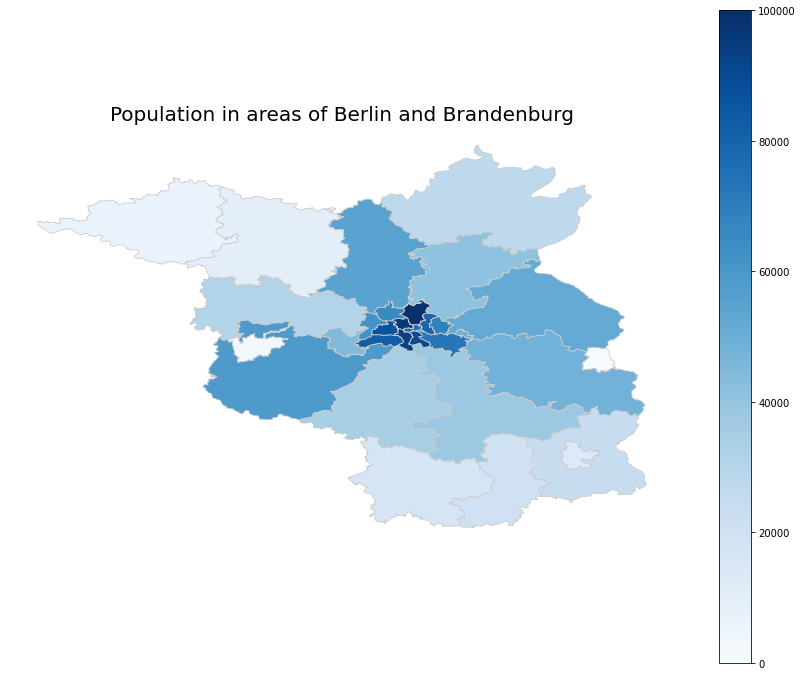

In [ ]:
#defining the range and axes
vmin, vmax = 0, 100000
fig, ax = plt.subplots(1, 1, figsize=[15,12])

# setting the parameters for the map
areas_df.plot(column='totalpopulation 2018', cmap='Blues', linewidth=0.8, ax = ax, edgecolor='0.8')
ax.tooltip=['Name']
ax.set_title('Population in areas of Berlin and Brandenburg', fontdict={'fontsize': '20', 'fontweight' : '2'})
ax.axis('off')

# legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## Towns and Municipalities 

The smallest spatial entities "(kreisangehörige Stadt", "Gemeinde" and "amtsangehörige Gemeinde") can also provides useful insights.

## Metropolitan Area: Towns and Municipalities 

As we want to have a closer look on the "Metropolitan Area", we'll have a closer look on the municipalities close to Berlin. Therefore we're extracting the data for these municipalities. Two steps are required: selecting the items by their administration level, in order to selecting only the smallest entities. Second, we're selecting only the municipalities belonging to the districts closest to Berlin (e.g. part of the "Metropolitan Area")

In [ ]:
#selecting the spatial entities by their administration level

municipalities_df = BrandenburgBerlin_df.loc[(BrandenburgBerlin_df['administrative_division'] == 'amtsangehörige Gemeinde') | (BrandenburgBerlin_df['administrative_division'] == 'kreisangehörige Stadt') | (BrandenburgBerlin_df['administrative_division'] == 'Gemeinde')]

#furthermore filtering the municipalities close to Berlin (Metropolitan Region) by their district

municipalities_metroregion_df = municipalities_df.loc[(municipalities_df['Landkreis'] == 'Oberhavel') | (municipalities_df['Landkreis'] == 'Barnim') | (municipalities_df['Landkreis'] == 'Märkisch-Oderland')| (municipalities_df['Landkreis'] == 'Oder-Spree') | (municipalities_df['Landkreis'] == 'Dahme-Spreewald') | (municipalities_df['Landkreis'] == 'Potsdam-Mittelmark')| (municipalities_df['Landkreis'] == 'Havelland')]
municipalities_metroregion_df

,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
24,12061332.0,8,"POLYGON ((13.48689 52.29842, 13.48636 52.29670...",Mittenwalde,kreisangehörige Stadt,Dahme-Spreewald,Brandenburg,8663,8683,8710,8724,8658,8663,8734,8774,8898,8950,9104,9140
25,12061433.0,8,"POLYGON ((13.49560 52.33089, 13.49656 52.33234...",Schönefeld,Gemeinde,Dahme-Spreewald,Brandenburg,12462,12831,13060,13256,13317,13453,13760,13895,14190,14423,14625,15472
26,12061112.0,8,"POLYGON ((13.61360 52.36459, 13.61291 52.36523...",Eichwalde,Gemeinde,Dahme-Spreewald,Brandenburg,6073,6114,6113,6205,6252,6305,6359,6421,6426,6490,6449,6468
27,12061444.0,8,"POLYGON ((13.60572 52.37769, 13.60651 52.37675...",Schulzendorf,Gemeinde,Dahme-Spreewald,Brandenburg,7564,7617,7662,7706,7575,7560,7633,7706,7872,7961,8167,8222
28,12061572.0,8,"POLYGON ((13.65405 52.33606, 13.65325 52.33604...",Zeuthen,Gemeinde,Dahme-Spreewald,Brandenburg,10344,10272,10290,10400,10574,10693,10811,10993,11106,11270,11297,11381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,12061492.0,8,"POLYGON ((13.63068 52.16021, 13.63177 52.16114...",Teupitz,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,1890,1870,1844,1831,1802,1786,1785,1812,1813,1868,1880,1917
430,12061448.0,8,"POLYGON ((13.65947 52.13377, 13.65985 52.13463...",Schwerin,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,602,613,637,630,780,794,792,815,814,815,820,847
431,12061192.0,8,"POLYGON ((13.59740 52.16237, 13.60183 52.17165...",GroßKöris,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,2271,2334,2340,2326,2224,2209,2209,2243,2253,2265,2294,2338
432,12061344.0,8,"POLYGON ((13.76162 52.14211, 13.76233 52.14214...",Münchehofe,amtsangehörige Gemeinde,Dahme-Spreewald,Brandenburg,528,514,498,492,482,486,477,481,469,470,472,474


#### 50 biggest municipalicies in the "Metropolitan Area"

We want to have a look on the spatial distributions of the most populous municipalities. Therefore I'm sorting the dataframe by population size. I'm selecting the 50 biggest municpalities to visualize them on a map.

In [ ]:
#sorting the dataframe by the population sizes
high_popul_municipalities_df = municipalities_metroregion_df.sort_values(by='totalpopulation 2018', ascending=False)

#selecting the first 50 items
high_popul_municipalities_df = high_popul_municipalities_df.iloc[0:50]

#and checking whether the selection worked
high_popul_municipalities_df

,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
182,12065256.0,8,"POLYGON ((13.18215 52.72387, 13.18214 52.72399...",Oranienburg,kreisangehörige Stadt,Oberhavel,Brandenburg,41488,41577,41590,41810,41370,41621,42028,42894,43526,44079,43982,44512
89,12063080.0,8,"POLYGON ((13.15239 52.57046, 13.15253 52.57072...",Falkensee,kreisangehörige Stadt,Havelland,Brandenburg,43844,39366,39821,40179,40511,40465,40905,41258,41777,42634,43105,43552
211,12060052.0,8,"POLYGON ((13.83914 52.81940, 13.84050 52.81849...",Eberswalde,kreisangehörige Stadt,Barnim,Brandenburg,41331,41175,40944,39126,38965,38844,38897,39303,40019,40223,40387,41396
30,12061260.0,8,"POLYGON ((13.64395 52.30735, 13.64401 52.30862...",Königs Wusterhausen,kreisangehörige Stadt,Dahme-Spreewald,Brandenburg,33370,33400,33762,33981,33747,33975,34240,34795,35765,36468,36706,37190
210,12060020.0,8,"POLYGON ((13.63810 52.62768, 13.63993 52.62777...",BernaubeiBerlin,kreisangehörige Stadt,Barnim,Brandenburg,36059,36154,36338,35843,36020,36222,36547,37169,37725,38194,38825,35859
399,12067144.0,8,"POLYGON ((13.98964 52.35043, 13.99135 52.36809...",Fürstenwalde/Spree,kreisangehörige Stadt,Oder-Spree,Brandenburg,33104,32867,32576,32468,30910,30885,30967,31236,31741,32025,32098,31941
312,12064472.0,8,"POLYGON ((13.81315 52.52333, 13.81689 52.52198...",Strausberg,kreisangehörige Stadt,Märkisch-Oderland,Brandenburg,26347,26229,26221,26206,25611,25594,25744,25946,26213,26387,26522,26587
172,12065136.0,8,"POLYGON ((13.21185 52.66423, 13.21310 52.66492...",Hennigsdorf,kreisangehörige Stadt,Oberhavel,Brandenburg,25891,25729,25900,25909,25597,25704,25800,25928,26264,26139,26369,26272
57,12069656.0,8,"POLYGON ((12.84892 52.42628, 12.85171 52.42816...",Werder(Havel),kreisangehörige Stadt,Potsdam-Mittelmark,Brandenburg,23145,23129,23004,23017,23297,23506,23838,24347,24856,25345,25695,26184
175,12065144.0,8,"POLYGON ((13.22925 52.67581, 13.23230 52.67378...",HohenNeuendorf,kreisangehörige Stadt,Oberhavel,Brandenburg,23549,23909,24139,24384,24585,24905,25001,25239,25519,25696,26001,26159


For an overview of those 50 municipalities, I'm creating a simple bar chart. With the help of the visualization, one can see that the spread of population size is still quite big between the most populous municipalities (40000-10000 inhabitants).

In [ ]:
# sorting the municipalities by their districts
high_popul_municipalities_df.sort_values(by=['Landkreis'])

,community identification number,admin_level,geometry,name,administrative_division,Landkreis,Bundesland,totalpopulation 2007,totalpopulation 2008,totalpopulation 2009,totalpopulation 2010,totalpopulation 2011,totalpopulation 2012,totalpopulation 2013,totalpopulation 2014,totalpopulation 2015,totalpopulation 2016,totalpopulation 2017,totalpopulation 2018
211,12060052.0,8,"POLYGON ((13.83914 52.81940, 13.84050 52.81849...",Eberswalde,kreisangehörige Stadt,Barnim,Brandenburg,41331,41175,40944,39126,38965,38844,38897,39303,40019,40223,40387,41396
210,12060020.0,8,"POLYGON ((13.63810 52.62768, 13.63993 52.62777...",BernaubeiBerlin,kreisangehörige Stadt,Barnim,Brandenburg,36059,36154,36338,35843,36020,36222,36547,37169,37725,38194,38825,35859
209,12060198.0,8,"POLYGON ((13.73151 52.90729, 13.73310 52.90788...",Schorfheide,Gemeinde,Barnim,Brandenburg,10241,10172,10234,9858,9837,9747,9759,9908,9966,9947,9999,10331
218,12060005.0,8,"POLYGON ((13.58154 52.57111, 13.58155 52.57104...",Ahrensfelde,Gemeinde,Barnim,Brandenburg,13090,13114,13028,12727,12761,12769,12856,12954,13068,13307,13543,13006
205,12060181.0,8,"POLYGON ((13.50473 52.61964, 13.50461 52.61959...",Panketal,Gemeinde,Barnim,Brandenburg,19167,19179,19132,19032,19249,19426,19721,20131,20353,20390,20519,19172
361,12060269.0,8,"POLYGON ((13.42702 52.63715, 13.42724 52.63728...",Wandlitz,Gemeinde,Barnim,Brandenburg,21237,21530,21704,20775,20945,21212,21656,22095,22363,22585,22937,21065
420,12061316.0,8,"POLYGON ((13.98729 51.92168, 13.98870 51.91975...",Lübben (Spreewald),kreisangehörige Stadt,Dahme-Spreewald,Brandenburg,14346,14250,14179,14122,13869,13815,13707,13672,13824,13861,13964,14024
426,12061320.0,8,"POLYGON ((13.75221 51.75409, 13.75239 51.75408...",Luckau,kreisangehörige Stadt,Dahme-Spreewald,Brandenburg,10452,10334,10231,10130,9818,9738,9610,9558,9533,9574,9729,9582
29,12061540.0,8,"POLYGON ((13.64395 52.30735, 13.64325 52.30731...",Wildau,kreisangehörige Stadt,Dahme-Spreewald,Brandenburg,9819,9911,9906,9898,9731,9797,9878,9945,9978,10057,10093,10303
28,12061572.0,8,"POLYGON ((13.65405 52.33606, 13.65325 52.33604...",Zeuthen,Gemeinde,Dahme-Spreewald,Brandenburg,10344,10272,10290,10400,10574,10693,10811,10993,11106,11270,11297,11381


In [ ]:

# creating the chart which shows the population figures of 2018
alt.Chart(high_popul_municipalities_df).mark_bar().encode(
    x='totalpopulation 2018',
    y=alt.Y('name', sort=alt.SortField(field='Landkreis', order='ascending')),
    color='Landkreis',
# adding a tooltip as it is quite hard so associate the items
    tooltip=['name', 'totalpopulation 2018', 'administrative_division'],
# adding formation
).properties(height=700
).properties(
    title='The 50 municipalities with the highest population figures in the Metropolitan Area Brandenburg 2018'
)


alt.Chart(...)

When hovering over the items, one can easily detect that the biggest entities are the towns. Then, the municipalities closest to Berlin (mostly connected with the local transport system such as Teltow, Hennigsdorf, Neunhagen etc.) are following.

# Conclusions

The analyses show that the population in Berlin and Brandenburg is very unequally distributed. In Berlin, many people live together in a very small area. But also the areas around Berlin have higher population figures than the more peripheral areas. This points to the close links between the two federal states mentioned in the introduction. 

In a next step, other indicators could be added to investigate other contexts or even reasons for these disparities (for example, economic data such as labour statistics or trade figures).